# HW 5

    Name: Trisha Mandal            Github username: trish11953             USC ID:1449602587

In [56]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import warnings
from sklearn.linear_model import RidgeCV
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from operator import itemgetter
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

In [30]:
import xgboost as xgb

# 1. Decision Trees as Interpretable Models

a) Download the Accute Inflamations data

In [3]:
df = pd.read_csv("../data/diagnosis.data",encoding='utf_16',sep="\t",header=None)
df = df.apply(lambda x: x.str.replace(',','.'))
df[0] = pd.to_numeric(df[0])
df.columns = ['1', '2', '3', '4', '5', '6', '7', '8']
for i in df.columns:
    df[i] = df[i].replace({'yes': 1, 'no': 0})
df

,1,2,3,4,5,6,7,8
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1
116,41.5,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1
118,41.5,0,1,1,0,1,0,1


b) Build a decision tree on the whole data set and plot it.

[Text(0.4, 0.9, 'X[0] <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.2, 0.7, 'X[2] <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.1, 0.5, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.3, 0.5, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.6, 0.7, 'X[2] <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.7, 0.5, 'X[4] <= 0.5\ngini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]'),
 Text(0.6, 0.3, 'gini = 0.0\nsamples = 21\nvalue = [[21, 0]\n[0, 21]]'),
 Text(0.8, 0.3, 'X[3] <= 0.5\ngini = 0.226\nsamples = 29\nvalue = [[10, 19]\n[0, 29]]'),
 Text(0.7, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[0, 10]]'),
 Text(0.9, 0.1, 'gini = 0.0\nsamples = 19\nvalue = [[0, 19]\n[0, 19]]')]

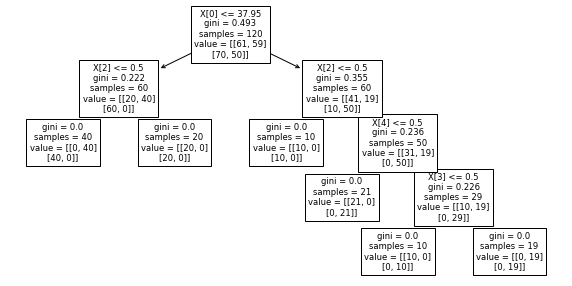

In [4]:
#reference: https://scikit-learn.org/stable/modules/tree.html
trainingX, trainingY  = df.iloc[:, 0:6], df.iloc[:,6:]
dtc = tree.DecisionTreeClassifier()
tre = dtc.fit(trainingX, trainingY)
plt.figure(figsize=(10,5))
tree.plot_tree(tre)

c) Convert the decision rules into a set of IF-THEN rules.

In [6]:
# reference: https://mljar.com/blog/extract-rules-decision-tree/
#taken from reference

def tree_to_code(tree, feature_names):

    tree_ = tree.tree_
    feature_name = []
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
tree_to_code(tre, df.columns)

  if 1 <= 37.95000076293945:
    if 3 <= 0.5:
      return [[ 0. 40.]
 [40.  0.]]
    else:  # if 3 > 0.5
      return [[20.  0.]
 [20.  0.]]
  else:  # if 1 > 37.95000076293945
    if 3 <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if 3 > 0.5
      if 5 <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if 5 > 0.5
        if 4 <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if 4 > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

[Text(0.5, 0.8333333333333334, '1 <= 37.95\ngini = 0.493\nsamples = 120\nvalue = [[61, 59]\n[70, 50]]'),
 Text(0.25, 0.5, '4 <= 0.5\ngini = 0.222\nsamples = 60\nvalue = [[20, 40]\n[60, 0]]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 20\nvalue = [[20, 0]\n[20, 0]]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 40\nvalue = [[0, 40]\n[40, 0]]'),
 Text(0.75, 0.5, '3 <= 0.5\ngini = 0.355\nsamples = 60\nvalue = [[41, 19]\n[10, 50]]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 10\nvalue = [[10, 0]\n[10, 0]]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.236\nsamples = 50\nvalue = [[31, 19]\n[0, 50]]')]

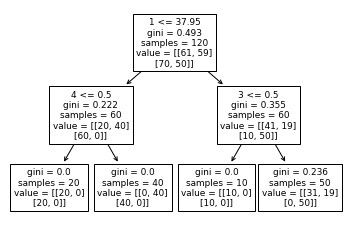

In [7]:
#reference: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

xtrain, xtest, ytrain, ytest = train_test_split(trainingX, trainingY, random_state=0)
classifier = DecisionTreeClassifier()
classifier.fit(xtrain , ytrain)
path = classifier.cost_complexity_pruning_path(xtrain, ytrain)
classifier2 = DecisionTreeClassifier(ccp_alpha =path.ccp_alphas[1])
classifier2 = classifier2.fit(trainingX, trainingY)
tree.plot_tree(classifier2 , feature_names=trainingX.columns)

In [8]:
tree_to_code(classifier2, trainingX.columns)

  if 1 <= 37.95000076293945:
    if 4 <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if 4 > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if 1 > 37.95000076293945
    if 3 <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if 3 > 0.5
      return [[31. 19.]
 [ 0. 50.]]


# 2. The LASSO and Boosting for Regression

a) Download the Communities and Crime data. Use the first 1495 rows of data as the training set and the rest as the test set.

In [9]:
df = pd.read_csv('../data/communities.names', usecols = [0])
commnames = df.iloc[56:184]
commnames = commnames.reset_index(drop=True)
namelist = commnames.iloc[:,0]
namelist

0                    @attribute state numeric
1                   @attribute county numeric
2                @attribute community numeric
3             @attribute communityname string
4                     @attribute fold numeric
                        ...                  
123    @attribute LemasPctPolicOnPatr numeric
124    @attribute LemasGangUnitDeploy numeric
125    @attribute LemasPctOfficDrugUn numeric
126        @attribute PolicBudgPerPop numeric
127    @attribute ViolentCrimesPerPop numeric
Name: Title: Communities and Crime, Length: 128, dtype: object

In [10]:
df2 = pd.read_csv('../data/communities.data', header = None, names = namelist)
df2 = df2.drop(['@attribute ViolentCrimesPerPop numeric','@attribute state numeric', '@attribute county numeric','@attribute community numeric','@attribute communityname string','@attribute fold numeric',], axis=1)
trainingset, testingset = df2.iloc[0:1495], df2.iloc[1495:] 
testingset = testingset.reset_index(drop=True)
trainingset

,@attribute population numeric,@attribute householdsize numeric,@attribute racepctblack numeric,@attribute racePctWhite numeric,@attribute racePctAsian numeric,@attribute racePctHisp numeric,@attribute agePct12t21 numeric,@attribute agePct12t29 numeric,@attribute agePct16t24 numeric,@attribute agePct65up numeric,...,@attribute PolicAveOTWorked numeric,@attribute LandArea numeric,@attribute PopDens numeric,@attribute PctUsePubTrans numeric,@attribute PolicCars numeric,@attribute PolicOperBudg numeric,@attribute LemasPctPolicOnPatr numeric,@attribute LemasGangUnitDeploy numeric,@attribute LemasPctOfficDrugUn numeric,@attribute PolicBudgPerPop numeric
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,?,0.02,0.12,0.45,?,?,?,?,0.00,?
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,?,0.01,0.21,0.02,?,?,?,?,0.00,?
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,?,0.02,0.39,0.28,?,?,?,?,0.00,?
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,?,0.04,0.09,0.02,?,?,?,?,0.00,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,?,0.02,0.14,0.22,?,?,?,?,0.00,?
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.38,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,?,0.03,0.12,0.01,?,?,?,?,0.00,?
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,?,0.08,0.15,0.02,?,?,?,?,0.00,?


In [11]:
testingset

,@attribute population numeric,@attribute householdsize numeric,@attribute racepctblack numeric,@attribute racePctWhite numeric,@attribute racePctAsian numeric,@attribute racePctHisp numeric,@attribute agePct12t21 numeric,@attribute agePct12t29 numeric,@attribute agePct16t24 numeric,@attribute agePct65up numeric,...,@attribute PolicAveOTWorked numeric,@attribute LandArea numeric,@attribute PopDens numeric,@attribute PctUsePubTrans numeric,@attribute PolicCars numeric,@attribute PolicOperBudg numeric,@attribute LemasPctPolicOnPatr numeric,@attribute LemasGangUnitDeploy numeric,@attribute LemasPctOfficDrugUn numeric,@attribute PolicBudgPerPop numeric
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,?,0.01,0.23,0.73,?,?,?,?,0.00,?
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,?,0.01,0.18,0.02,?,?,?,?,0.00,?
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,?,0.01,0.18,0.00,?,?,?,?,0.00,?
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,?,0.06,0.13,0.16,?,?,?,?,0.00,?
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,?,0.03,0.23,0.06,?,?,?,?,0.00,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,?,0.01,0.28,0.05,?,?,?,?,0.00,?
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,?,0.02,0.37,0.20,?,?,?,?,0.00,?
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.19,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18


b) Use a data imputation technique to deal with the missing values in the data set.

In [12]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
trainingset, testingset= trainingset.replace('?',np.nan), testingset.replace('?',np.nan)
imputer = SimpleImputer(missing_values=np.nan,strategy="median")
imputer = imputer.fit(trainingset)
traindata, testdata = pd.DataFrame(imputer.transform(trainingset)), pd.DataFrame(imputer.transform(testingset))
traindata

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.28,0.02,0.12,0.45,0.07,0.03,0.76,0.5,0.00,0.15
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.28,0.01,0.21,0.02,0.07,0.03,0.76,0.5,0.00,0.15
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.28,0.02,0.39,0.28,0.07,0.03,0.76,0.5,0.00,0.15
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.28,0.04,0.09,0.02,0.07,0.03,0.76,0.5,0.00,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.00,0.59,0.01,0.69,1.00,0.07,0.41,0.28,0.23,0.57,...,0.28,0.02,0.14,0.22,0.07,0.03,0.76,0.5,0.00,0.15
1491,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.38,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19
1492,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.28,0.03,0.12,0.01,0.07,0.03,0.76,0.5,0.00,0.15
1493,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.28,0.08,0.15,0.02,0.07,0.03,0.76,0.5,0.00,0.15


In [13]:
testdata

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,0.00,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.28,0.01,0.23,0.73,0.07,0.03,0.76,0.5,0.00,0.15
1,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.28,0.01,0.18,0.02,0.07,0.03,0.76,0.5,0.00,0.15
2,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.28,0.01,0.18,0.00,0.07,0.03,0.76,0.5,0.00,0.15
3,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.28,0.06,0.13,0.16,0.07,0.03,0.76,0.5,0.00,0.15
4,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.28,0.03,0.23,0.06,0.07,0.03,0.76,0.5,0.00,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.28,0.01,0.28,0.05,0.07,0.03,0.76,0.5,0.00,0.15
495,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.28,0.02,0.37,0.20,0.07,0.03,0.76,0.5,0.00,0.15
496,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.25,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28
497,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.19,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18


c) Plot a correlation matrix for the features in the data set.

<AxesSubplot:>

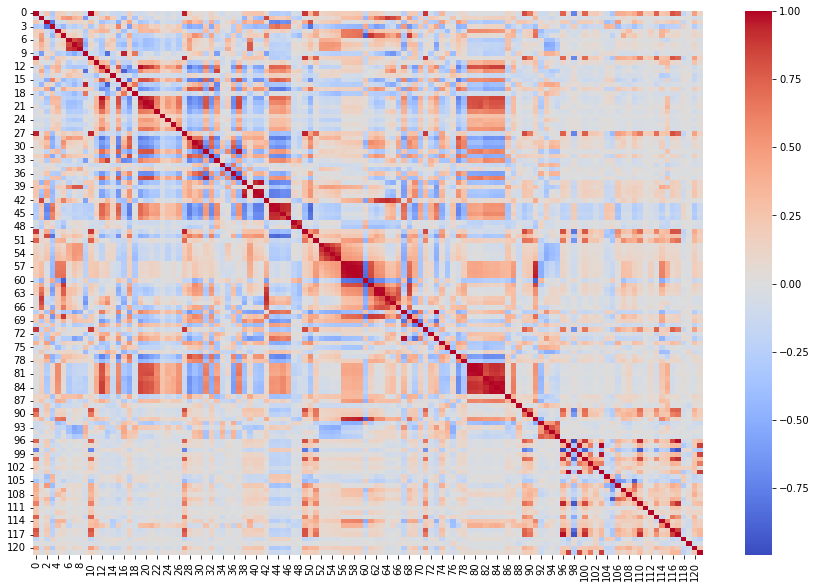

In [14]:
#reference: https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(traindata.corr(), ax = ax, cmap='coolwarm')


d) Calculate the Coefficient of Variation CV for each feature, where CV = ms , in
which s is sample standard deviation and m is sample mean..

In [16]:
xtrain, ytrain = traindata.iloc[:, :122], traindata.iloc[:, -1]
xtest, ytest = testdata.iloc[:, :122], testdata.iloc[:, -1]
CVdf=pd.DataFrame(xtrain.apply(lambda x: np.std(x)/np.mean(x)), columns=["CV for training set"])
CVdf

,CV for training set
0,2.240355
1,0.355681
2,1.428407
3,0.330102
4,1.358645
...,...
117,1.644957
118,0.111995
119,0.334992
120,2.552092


e) pick floor of $\sqrt{128}$ features with highest CV , and make scatter plots and box plots for them. Can you draw conclusions about significance of those features, just by the scatter plots?

In [17]:
x = math.floor(math.sqrt(128))
x

11

In [18]:
top11 = CVdf.nlargest(11,"CV for training set" , keep='first')
top11

,CV for training set
108,5.525210
90,4.291487
89,3.469791
49,3.057941
51,2.925656
120,2.552092
27,2.341660
96,2.247290
0,2.240355
10,2.037780


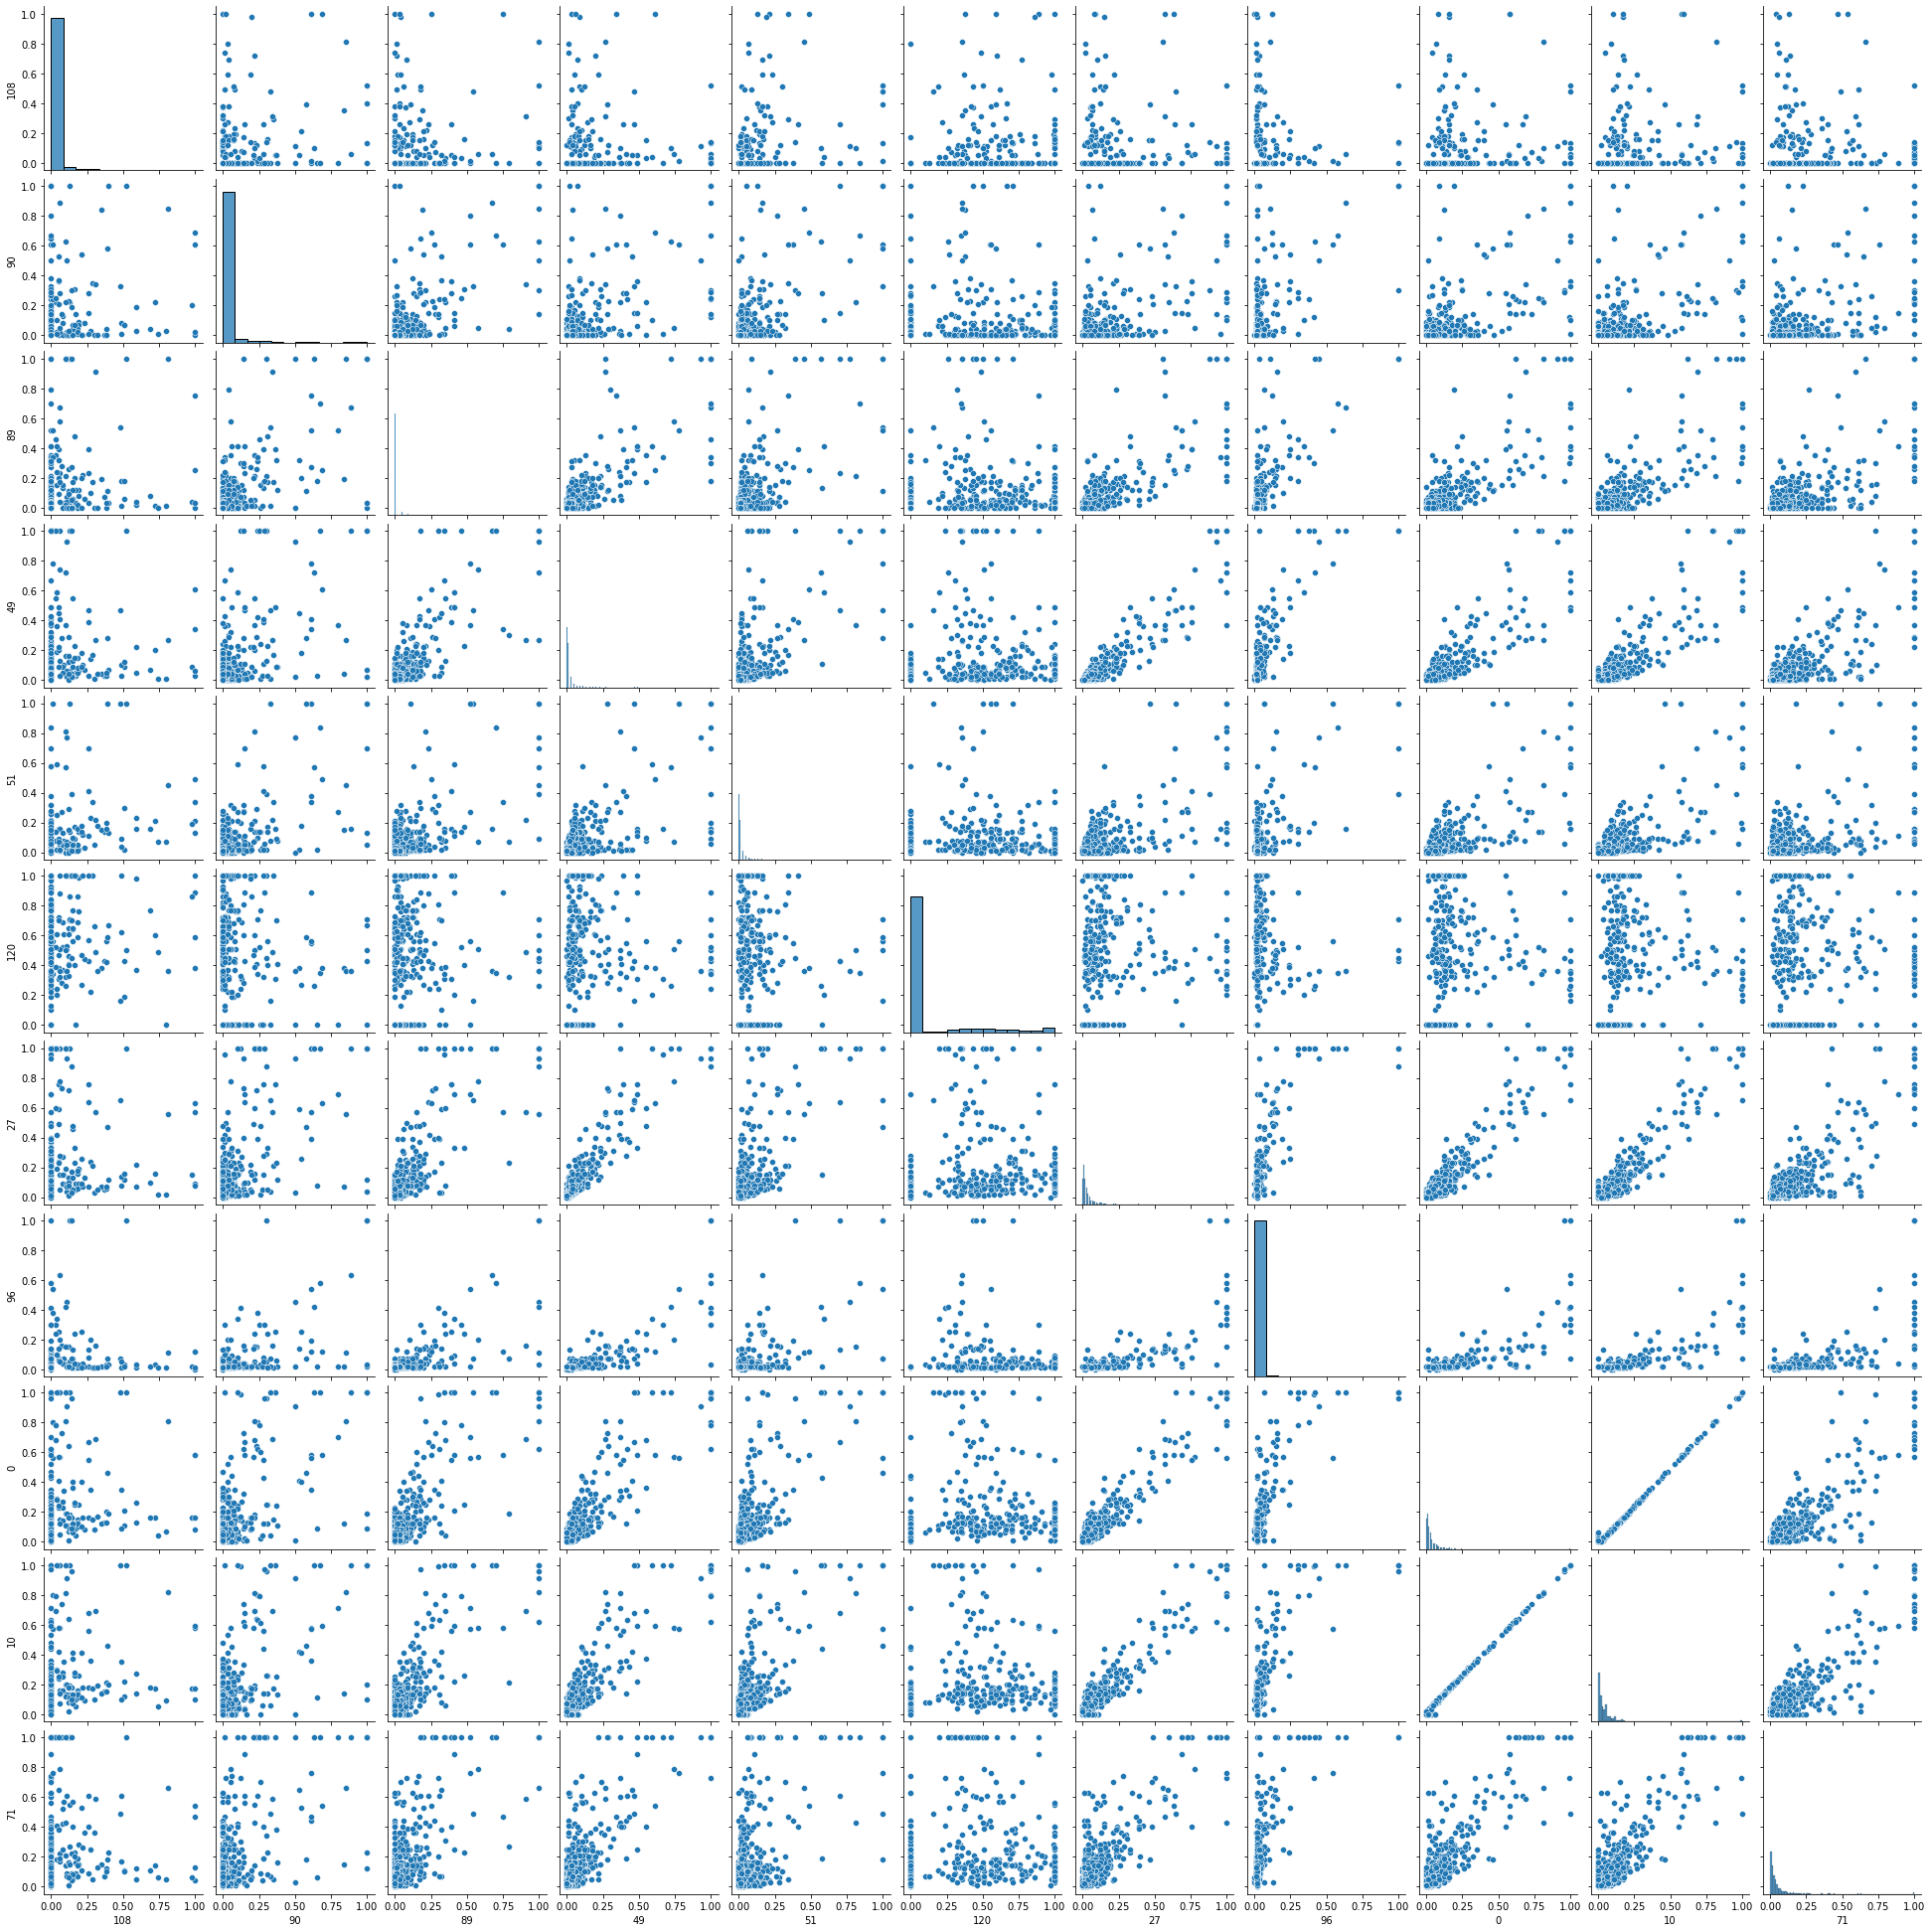

In [19]:
plottingdata = traindata[[108,90,89,49,51,120,27,96,0,10,71]]
sns.pairplot(plottingdata)
plt.show()

<AxesSubplot:>

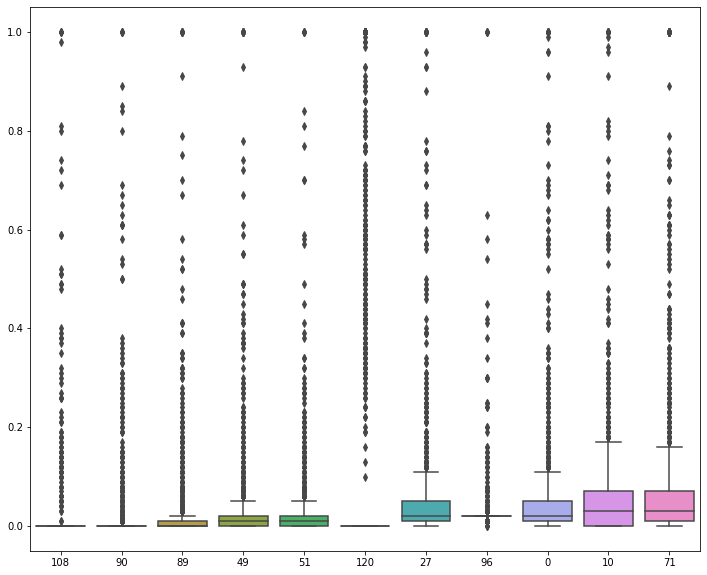

In [20]:
plt.figure(figsize=(12,10))
sns.boxplot(data = plottingdata)

The scatter plot shows us that some of the features are perfectly linear and some are very closely correlated. This makes it difficult to draw any conclusions about the significance of those features from the scatter plot. The boxplot shows us that the variables have high varaiance and that their mean would be relatively small.

f) Fit a linear model using least squares to the training set and report the test error.

In [48]:
xtrain, ytrain = traindata.iloc[:,:-1], traindata.iloc[:,-1]
xtest, ytest = testdata.iloc[:,:-1], testdata.iloc[:,-1]
lr = LinearRegression()
lr = lr.fit(xtrain, ytrain)
prediction = lr.predict(xtest)
print("Test MSE for Linear Regression: ", metrics.mean_squared_error(ytest,prediction))

Test MSE for Linear Regression:  9.002453773277069e+17


g) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [52]:
ridgemodel = RidgeCV()
ridgemodel = ridgemodel.fit(xtrain, ytrain) 
prediction =ridgemodel.predict(xtest)
print("Test MSE for Ridge Regression: ", metrics.mean_squared_error(ytest,prediction))

Test MSE for Ridge Regression:  0.0012029362288986417


h) Fit a LASSO model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with a list of the variables selected by the model. Repeat with standardized4 features. Report the test error for both cases and compare them.


In [53]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

lasso = LassoCV(cv=5, random_state=0,normalize=False)
lasso = lasso.fit(xtrain, ytrain)
prediction = lasso.predict(xtest)
print("Test MSE for LASSO Cross Validation: ", metrics.mean_squared_error(ytest,prediction))
cols = xtrain.columns
print("Selected Variables: ",[name for i, name in enumerate(cols) if (lasso.coef_[i]!=0)])

Test MSE for LASSO Cross Validation:  0.0012558258910164352
Selected Variables:  [2, 3, 4, 5, 6, 7, 9, 11, 14, 16, 17, 18, 19, 22, 23, 26, 27, 29, 32, 33, 34, 36, 38, 40, 44, 45, 46, 48, 49, 51, 52, 53, 59, 61, 63, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 82, 84, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 119, 120]


In [55]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
std = StandardScaler()
stdxtrain, stdxtest = std.fit_transform(xtrain), std.fit_transform(xtest)
stdlasso = LassoCV(cv=5, random_state=0, normalize=False)
stdlasso = stdlasso.fit(stdxtrain, ytrain)
yprediction =stdlasso.predict(stdxtest)
print("Test MSE for LASSO Cross Validation with Standardised features: ", metrics.mean_squared_error(ytest,yprediction))
print("Selected Variables: ", (xtrain.columns[np.where(stdlasso.coef_!=0)]))

Test MSE for LASSO Cross Validation with Standardised features:  0.0017577942501115784
Selected Variables:  Int64Index([  4,  11,  17,  18,  20,  23,  24,  29,  32,  34,  40,  45,  46,
             49,  51,  52,  59,  69,  72,  76,  79,  89,  92,  94,  95,  96,
             97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
            110, 111, 112, 116, 117, 119, 120],
           dtype='int64')


Standardised and non-standardised Lasso Regression models don't have much difference in their testing errors. 

i) Fit a PCR model on the training set, with M (the number of principal compo- nents) chosen by cross-validation. Report the test error obtained.

In [25]:
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

pcrmod = make_pipeline(PCA(n_components=1), LinearRegression())
pcrmod = pcrmod.fit(xtrain, ytrain)
prediction = pcrmod.predict(xtest)
print("Test MSE for PCR model: ", metrics.mean_squared_error(ytest,prediction))

Test MSE for PCR model:  0.006140568438608941


j) In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use L1-penalized regression at each node. Such a tree is called L1 penalized gradient boosting tree. You can use XGBoost5 to fit the model tree. Determine α (the regularization term) using cross-validation.

In [39]:
#reference: https://www.geeksforgeeks.org/xgboost-for-regression/

xgboost = xgb.XGBRegressor()
xgboost = xgboost.fit(xtrain, ytrain)
pred = xgboost.predict(xtest)
print("Test MSE for XGBoost:" ,metrics.mean_squared_error(ytest, prediction))

Test MSE for XGBoost: 0.0020101968461509285


# References: 

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/

https://scikit-learn.org/stable/modules/tree.html

https://mljar.com/blog/extract-rules-decision-tree/

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://www.geeksforgeeks.org/xgboost-for-regression/